In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

Load in cross section data

In [2]:
interactions = ["Be9_el", "F19_el", "Li6_el", "Li7_el", "Li6_T", "Li7_T", "Th232_abs", "U238_abs", "Th232_el", "U238_el"]
sig = {}
E = {}


In [3]:
for my_interaction in interactions:
    f = np.loadtxt(my_interaction + ".txt", skiprows = 11, dtype=np.float64)
    E[my_interaction] = f[:, 0]
    sig[my_interaction] = f[:, 1]

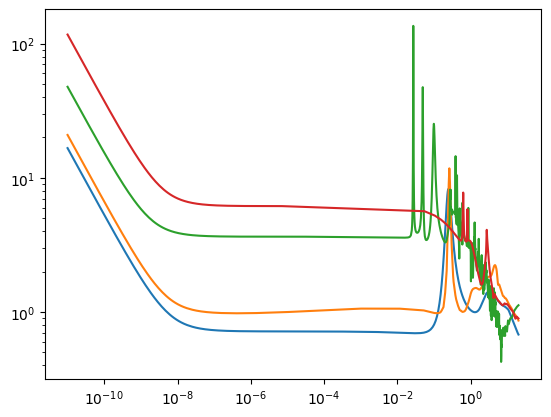

In [9]:
isotope = "Li6_el"
plt.loglog(E[isotope], sig[isotope], label = "Li-6")

isotope = "Li7_el"
plt.loglog(E[isotope], sig[isotope], label = "Li-7")

isotope = "F19_el"
plt.loglog(E[isotope], sig[isotope], label = "F-19")

isotope = "Be9_el"
plt.loglog(E[isotope], sig[isotope], label = "B-9")




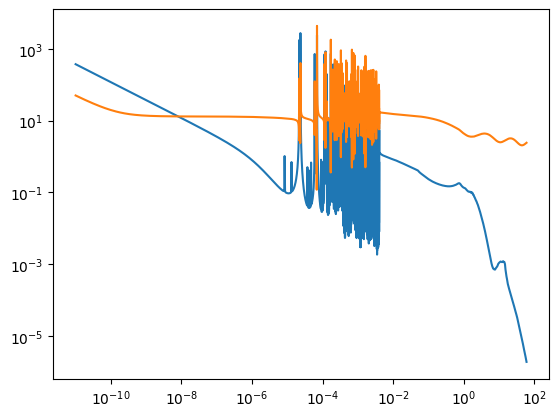

In [13]:
isotope = "Th232_abs"
plt.loglog(E[isotope], sig[isotope], label = "Th-232")

isotope = "Th232_el"
plt.loglog(E[isotope], sig[isotope], label = "U-238")

In [15]:
is_Th = True
#whether or not the fertile material is Th232. If False, it is U238.

Reactor and blanket size

In [16]:
R = 2.76 #m, reactor radius
d = 1.1 #m, blanket thickness
############################################

V_tot = 4*np.pi * ((R+d)**3 - R**3) / 3 #total blanket volume
print(f"Total blanket volume: {V_tot} m^3")

Total blanket volume: 152.84007433742124 m^3


Relative densities of all isotopes in the blanket

In [ ]:
mol = 6.023e23

#number of fertile atoms, based on IAEA maximum unreportable mass
if is_Th:
    N_fertile = 5.19e28 #Th232
else:
    N_fertile = 2.53e28 #U238

#molar density in mol/m^3, from Wolfram Alpha
if is_Th:
    rhoM_fertile = 19800 #ThF4
else:
    rhoM_fertile = 21340 #UF4

#Lithium fraction
Li6_frac = 0.0759
Li7_frac = 1 - Li6_frac

##########################################

V_fertile = N_fertile / mol / rhoM_fertile #total volume of fertile material
Vfrac_fertile = V_fertile / V_tot
Vfrac_FLiBe = 1 - Vfrac_fertile
V_FLiBe = V_tot * Vfrac_FLiBe
print(f"Fraction of blanket which is fertile material: {Vfrac_fertile}")
print(f"Fraction of blanket which is FLiBe: {Vfrac_FLiBe}")

rhoM_FLiBe = 19620 #mol/m^3
N_FLiBe = rhoM_FLiBe * V_FLiBe * mol

#Number densities of all species in m^-3

n_fertile = N_fertile / V_tot
n_FLiBe = N_FLiBe / V_tot

n_F19 = n_FLiBe * 4 + n_fertile * 4
n_Li6 = n_FLiBe * 2 * Li6_frac
n_Li7 = n_FLiBe * 2 * Li7_frac
n_Be9 = n_FLiBe * 1

print()
print(f"Number density of F19: {n_F19} m^-3")
print(f"Number density of Li6: {n_Li6} m^-3")
print(f"Number density of Li7: {n_Li7} m^-3")
print(f"Number density of Be9: {n_Be9} m^-3")
print(f"Number density of fertile isotope: {n_fertile} m^-3")


Fraction of blanket which is fertile material: 0.028474234946825248
Fraction of blanket which is FLiBe: 0.9715257650531748

Number density of F19: 4.72808520228301e+28 m^-3
Number density of Li6: 1.742761512962148e+27 m^-3
Number density of Li7: 2.1218523242797383e+28 m^-3
Number density of Be9: 1.1480642377879764e+28 m^-3
Number density of fertile isotope: 3.395706278277624e+26 m^-3


Some useful functions

In [20]:
def dp(n0, E0, sig, E):
    sig0 = np.interp(E0, E, sig)
    return n0 * sig0 * 10**-28 #to convert barns to m^2

def xi(A):
    return 1 + (A - 1)**2 / (2*A) * np.log((A - 1) / (A + 1))


Approximate the neutron energy moderation

In [ ]:
N_points = 1000

r = np.linspace(0, d, N_points)
dr = d / (N_points - 1)
Er = np.zeros(N_points) #MeV

#fractions
f0 = np.zeros(N_points)
fT = np.zeros(N_points)
fint = np.zeros(N_points)

#tracking fertile dp over the blanket
dp_array = np.zeros(N_points)

f0_current = 1
fT_current = 0
fint_current = 0

E_current = 14.1 #MeV

for i in range(N_points):
    #add current values to arrays
    Er[i] = E_current
    f0[i] = f0_current
    fT[i] = fT_current
    fint[i] = fint_current

    dp_array[i] = (dp(n_fertile, E_current, sig["Th232_abs"], E["Th232_abs"]) * dr * is_Th
                +dp(n_fertile, E_current, sig["U238_abs"], E["U238_abs"]) * dr * (not is_Th))


    Nscatter_F = dp(n_F19, E_current, sig["F19_el"], E["F19_el"]) * dr
    Nscatter_Be = dp(n_Be9, E_current, sig["Be9_el"], E["Be9_el"]) * dr
    Nscatter_Li6 = dp(n_Li6, E_current, sig["Li6_el"], E["Li6_el"]) * dr
    Nscatter_Li7 = dp(n_Li7, E_current, sig["Li7_el"], E["Li7_el"]) * dr

    #only one of these will be correct because there is only one n_fertile, but only one will be used.
    Nscatter_Th232 = dp(n_fertile, E_current, sig["Th232_el"], E["Th232_el"]) * dr
    Nscatter_U238 = dp(n_fertile, E_current, sig["U238_el"], E["U238_el"]) * dr

    #Update fractions
    fT_current += f0_current*(dp(n_Li6, E_current, sig["Li6_T"], E["Li6_T"]) * dr
              +dp(n_Li7, E_current, sig["Li7_T"], E["Li7_T"]) * dr)
    fint_current += f0_current*(dp(n_fertile, E_current, sig["Th232_abs"], E["Th232_abs"]) * dr * is_Th
                +dp(n_fertile, E_current, sig["U238_abs"], E["U238_abs"]) * dr * (not is_Th))
    f0_current = 1 - fT_current - fint_current + dp(n_Li7, E_current, sig["Li7_T"], E["Li7_T"]) * dr*0

    #Update energy
    E_current = E_current / np.exp(
        Nscatter_F * xi(19)
        + Nscatter_Be * xi(9)
        + Nscatter_Li6 * xi(6)
        + Nscatter_Li7 * xi(7)
        + Nscatter_Th232 * xi(232) * is_Th
        + Nscatter_U238 * xi(238) * (not is_Th)
        )


In [ ]:
fint[-1]

0.00031626093483337137

In [ ]:
fint[-1]

0.00011338507354055736

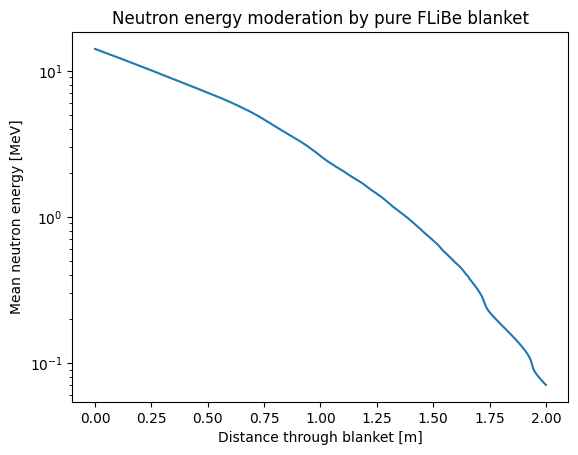

In [ ]:
plt.semilogy(r, Er)
plt.title("Neutron energy moderation by pure FLiBe blanket")
plt.xlabel("Distance through blanket [m]")
plt.ylabel("Mean neutron energy [MeV]")
plt.savefig("n_moderation_pure_FLiBe.png", dpi = 600, bbox_inches="tight")

In [ ]:
dp_th = dp_array.copy()
f0_th = f0.copy()

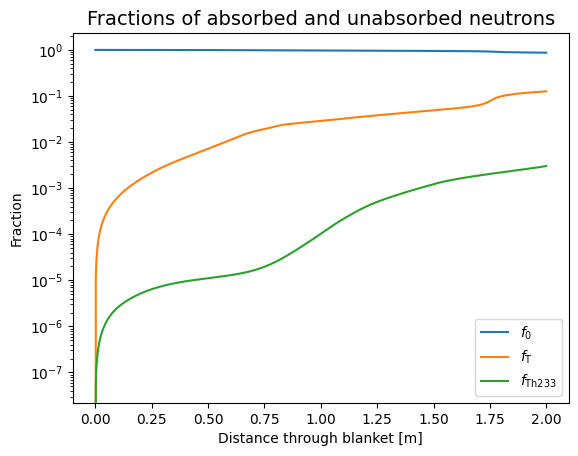

In [ ]:
plt.semilogy(r, f0, label = r"$f_0$")
plt.plot(r, fT, label = r"$f_{\mathrm{T}}$")
plt.plot(r, fint, label = r"$f_{\mathrm{Th233}}$")
plt.legend()
plt.title("Fractions of absorbed and unabsorbed neutrons", fontsize = 14)
plt.ylabel("Fraction")
plt.xlabel("Distance through blanket [m]")
plt.savefig("neutron_fractions_Th232.png", dpi = 600, bbox_inches="tight")

In [ ]:
fint[-1]

0.0030207342279088686

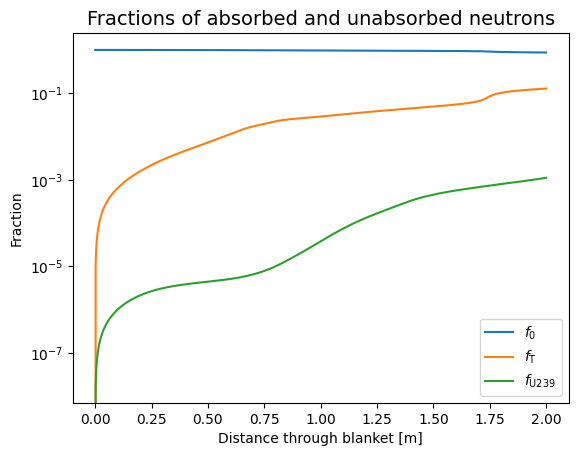

In [ ]:
plt.semilogy(r, f0, label = r"$f_0$")
plt.plot(r, fT, label = r"$f_{\mathrm{T}}$")
plt.plot(r, fint, label = r"$f_{\mathrm{U239}}$")
plt.legend()
plt.title("Fractions of absorbed and unabsorbed neutrons", fontsize = 14)
plt.ylabel("Fraction")
plt.xlabel("Distance through blanket [m]")
plt.savefig("neutron_fractions_U238.png", dpi = 600, bbox_inches="tight")

In [ ]:
fint[-1]

0.0011129157479061135

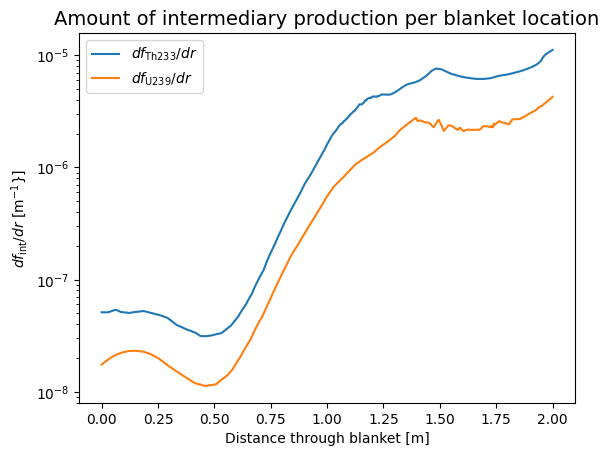

In [ ]:
plt.semilogy(r, f0_th*dp_th, label = "$df_{\mathrm{Th233}}/dr$")
plt.plot(r, f0_u*dp_u, label = "$df_{\mathrm{U239}}/dr$")
plt.title("Amount of intermediary production per blanket location", fontsize = 14)
plt.ylabel(r"$df_{\mathrm{int}}/dr$ [$\mathrm{m^{-1}}$}]")
plt.xlabel("Distance through blanket [m]")
plt.legend()
plt.savefig("df_dr.png", dpi = 600, bbox_inches="tight")

In [ ]:
0.00031626093483337137*1.862e20

5.888778606597375e+16

In [ ]:
0.00011338507354055736*1.862e20

2.111230069325178e+16

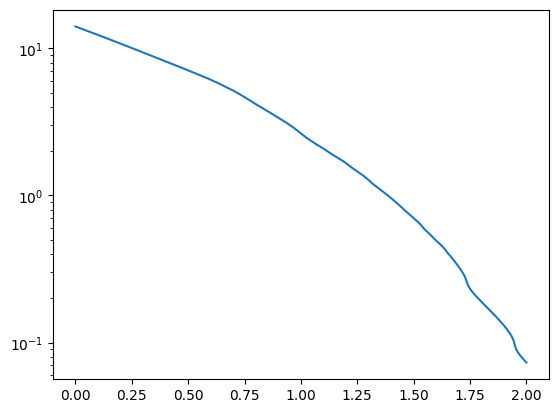

In [ ]:
plt.semilogy(r, Er)

Calculate amount of time to breed SQ

In [ ]:
r_Th233 = 5.888778606597375e+16 * 86400 #/day
r_U239 = 2.111230069325178e+16 * 86400

tau_Th233 = 29.975
tau_U239 = 2.356

SQ_U233 = 2.07e25
SQ_Pu239 = 2.02e25

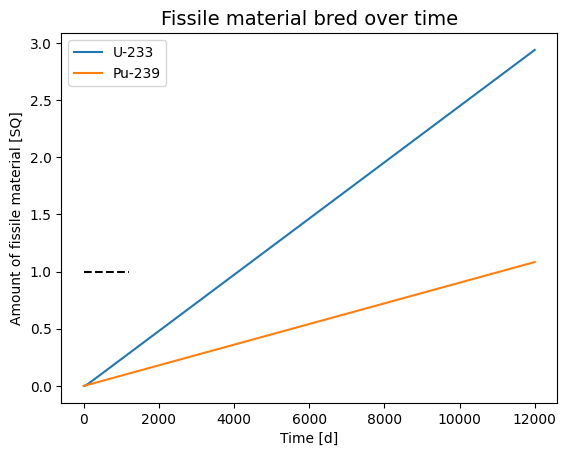

In [ ]:
t = np.linspace(0, 12000, 12001)

U233_amt = r_Th233 * (t+tau_Th233/np.log(2) * np.exp(-t*np.log(2) / tau_Th233)-tau_Th233/np.log(2))
Pu239_amt = r_U239 * (t+tau_U239/np.log(2) * np.exp(-t*np.log(2) / tau_U239)-tau_U239/np.log(2))

plt.plot(t, U233_amt/SQ_U233, label = "U-233")
plt.plot(t, Pu239_amt/SQ_Pu239, label = "Pu-239")
plt.plot([0, 1200], [1, 1], color = 'black', linestyle = 'dashed')
plt.legend()
plt.title("Fissile material bred over time", fontsize = 14)
plt.ylabel("Amount of fissile material [SQ]")
plt.xlabel("Time [d]")
plt.savefig("fissile_material_breeding", dpi = 600, bbox_inches="tight")

In [ ]:
t[np.where(U233_amt/SQ_U233>1)[0][0]]

4112.0

In [ ]:
t[np.where(Pu239_amt/SQ_Pu239>1)[0][0]]

11078.0

In [ ]:
189/30

6.3

Scaling of $d$

In [18]:
M = 30
th_rate = np.zeros((M, M))
T_rate = np.zeros((M, M))
is_Th = True

In [22]:
R_array = np.linspace(0, 5, M)
d_array = np.linspace(0.5, 3, M)
mol = 6.023e23

for iR, R in enumerate(R_array):
    for jd, d in enumerate(d_array):
        is_Th = False
        V_tot = 4*np.pi * ((R+d)**3 - R**3)/3 #total blanket volume
        #number of fertile atoms, based on IAEA maximum unreportable mass
        if is_Th:
            N_fertile = 5.19e28 * 0 #Th232
        else:
            N_fertile = 2.53e28 #U238

        #molar density in mol/m^3, from Wolfram Alpha
        if is_Th:
            rhoM_fertile = 19800 #ThF4
        else:
            rhoM_fertile = 21340 #UF4

        #Lithium fraction
        Li6_frac = 0.0759
        Li7_frac = 1 - Li6_frac

        ##########################################

        V_fertile = N_fertile / mol / rhoM_fertile #total volume of fertile material
        Vfrac_fertile = V_fertile / V_tot
        Vfrac_FLiBe = 1 - Vfrac_fertile
        V_FLiBe = V_tot * Vfrac_FLiBe

        rhoM_FLiBe = 19620 #mol/m^3
        N_FLiBe = rhoM_FLiBe * V_FLiBe * mol

        #Number densities of all species in m^-3

        n_fertile = N_fertile / V_tot
        n_FLiBe = N_FLiBe / V_tot

        n_F19 = n_FLiBe * 4 + n_fertile * 4
        n_Li6 = n_FLiBe * 2 * Li6_frac
        n_Li7 = n_FLiBe * 2 * Li7_frac
        n_Be9 = n_FLiBe * 1

        #####
        N_points = 1000

        r = np.linspace(0, d, N_points)
        dr = d / (N_points - 1)
        Er = np.zeros(N_points) #MeV

        #fractions
        f0 = np.zeros(N_points)
        fT = np.zeros(N_points)
        fint = np.zeros(N_points)

        #tracking fertile dp over the blanket
        dp_array = np.zeros(N_points)

        f0_current = 1
        fT_current = 0
        fint_current = 0

        E_current = 14.1 #MeV

        for i in range(N_points):
            #add current values to arrays
            Er[i] = E_current
            f0[i] = f0_current
            fT[i] = fT_current
            fint[i] = fint_current

            dp_array[i] = (dp(n_fertile, E_current, sig["Th232_abs"], E["Th232_abs"]) * dr * is_Th
                        +dp(n_fertile, E_current, sig["U238_abs"], E["U238_abs"]) * dr * (not is_Th))


            Nscatter_F = dp(n_F19, E_current, sig["F19_el"], E["F19_el"]) * dr
            Nscatter_Be = dp(n_Be9, E_current, sig["Be9_el"], E["Be9_el"]) * dr
            Nscatter_Li6 = dp(n_Li6, E_current, sig["Li6_el"], E["Li6_el"]) * dr
            Nscatter_Li7 = dp(n_Li7, E_current, sig["Li7_el"], E["Li7_el"]) * dr

            #only one of these will be correct because there is only one n_fertile, but only one will be used.
            Nscatter_Th232 = dp(n_fertile, E_current, sig["Th232_el"], E["Th232_el"]) * dr
            Nscatter_U238 = dp(n_fertile, E_current, sig["U238_el"], E["U238_el"]) * dr

            #Update fractions
            fT_current += f0_current*(dp(n_Li6, E_current, sig["Li6_T"], E["Li6_T"]) * dr
                    +dp(n_Li7, E_current, sig["Li7_T"], E["Li7_T"]) * dr)
            fint_current += f0_current*(dp(n_fertile, E_current, sig["Th232_abs"], E["Th232_abs"]) * dr * is_Th
                        +dp(n_fertile, E_current, sig["U238_abs"], E["U238_abs"]) * dr * (not is_Th))
            f0_current = 1 - fT_current - fint_current + dp(n_Li7, E_current, sig["Li7_T"], E["Li7_T"]) * dr

            #Update energy
            E_current = E_current / np.exp(
                Nscatter_F * xi(19)
                + Nscatter_Be * xi(9)
                + Nscatter_Li6 * xi(6)
                + Nscatter_Li7 * xi(7)
                + Nscatter_Th232 * xi(232) * is_Th
                + Nscatter_U238 * xi(238) * (not is_Th)
                )
        th_rate[iR, jd] = fint[-1]
        T_rate[iR, jd] = fT[-1]
    print(iR)
    print(fint[-1])





np.savetxt("u_rate.csv", th_rate, delimiter = ',')
np.savetxt("flibe_T.csv", T_rate, delimiter = ',')


0
0.012856781479582712
1
0.009807287502217155
2
0.01018115499933644
3
0.009558615938220733
4
0.008293497246876412
5
0.007240343477480496
6
0.007702989116352307
7
0.005595863547483553
8
0.005443742563969088
9
0.005182027443167908
10
0.004224335653362443
11
0.00454541609751435
12
0.0033049689359790023
13
0.003268769639894073
14
0.0025622707892308263
15
0.0027648261341806203
16
0.0028346448845727196
17
0.002271249544858475
18
0.0021478067743497735
19
0.002415150471257552
20
0.002083018174506819
21
0.0020008209232946386
22
0.0015667846606197797
23
0.0014092317738878652
24
0.001559843886717925
25
0.0014479652918666882
26
0.0012152414756907428
27
0.0013020840534045013
28
0.0009642727748186672
29
0.001140673502040434


In [36]:
d_array[7]

1.103448275862069

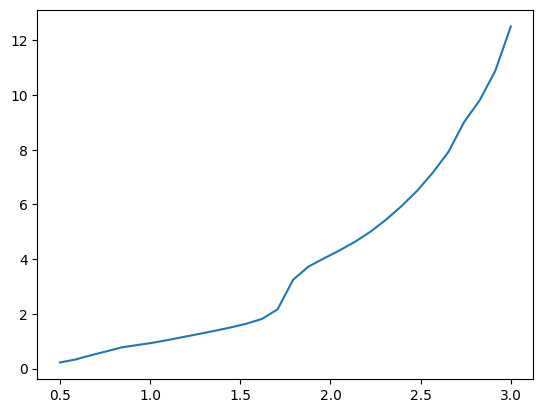

In [37]:
plt.plot(d_array, T_rate[15, :] * 1.05 / T_rate[15, 7])


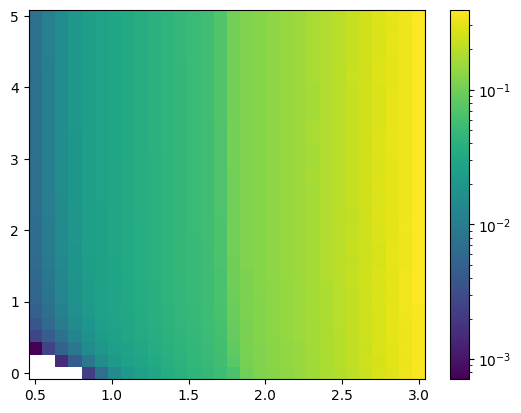

In [24]:
plt.pcolormesh(d_array, R_array, T_rate, norm = colors.LogNorm())
plt.colorbar()

In [ ]:
data = np.loadtxt("th_rate.csv", delimiter=  ',')

In [ ]:
data - th_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Text(0, 0.5, 'R')

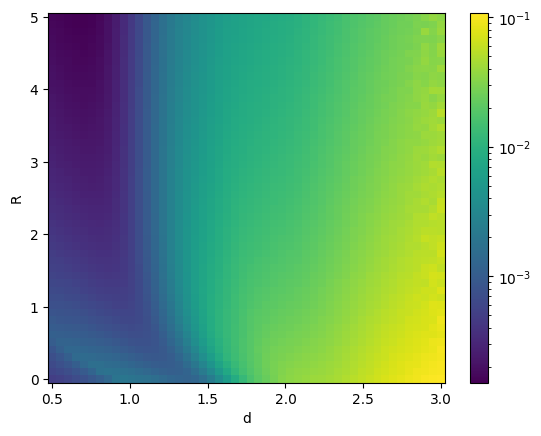

In [ ]:
plt.pcolormesh(d_array, R_array, data, norm = colors.LogNorm())
plt.colorbar()
plt.xlabel("d")
plt.ylabel("R")

Text(0, 0.5, 'R')

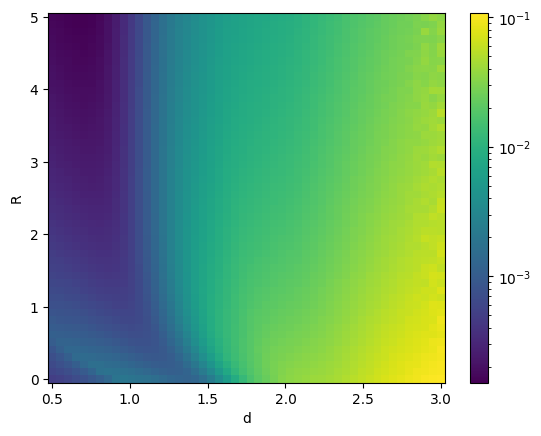

In [ ]:
plt.pcolormesh(d_array, R_array, th_rate, norm = colors.LogNorm())
plt.colorbar()
plt.xlabel("d")
plt.ylabel("R")

In [ ]:
d_array

array([0.5       , 0.77777778, 1.05555556, 1.33333333, 1.61111111,
       1.88888889, 2.16666667, 2.44444444, 2.72222222, 3.        ])

In [ ]:
th_rate[9, 5]

0.007907526843654353

In [ ]:
th_rate = np.loadtxt("th_rate.csv", delimiter = ',')
u_rate = np.loadtxt("u_rate.csv", delimiter = ',')

th_T = np.loadtxt("th_T.csv", delimiter = ',')
u_T = np.loadtxt("u_T.csv", delimiter = ',')

Text(0, 0.5, 'R')

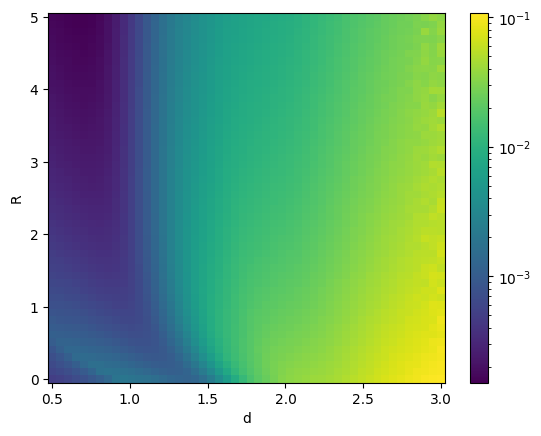

In [ ]:
plt.pcolormesh(d_array, R_array, th_rate, norm = colors.LogNorm())
plt.colorbar()
plt.xlabel("d")
plt.ylabel("R")

Text(0, 0.5, 'R')

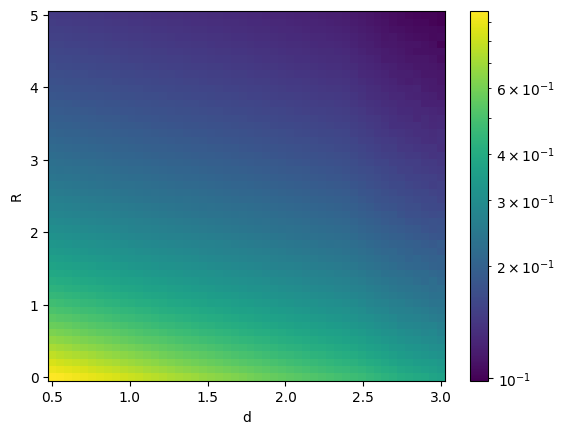

In [ ]:
plt.pcolormesh(d_array, R_array, u_rate, norm = colors.LogNorm())
plt.colorbar()
plt.xlabel("d")
plt.ylabel("R")